In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.arima.model import ARIMA as ARIMA_NEW
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

# Officer Impact on NTE Offences
## Cleaning and Summary Statistics
We begin by importing our data and dependencies, and running some summary statistics.

Our data is held in a CSV file.  This contains all crimes and officer presence only on weekends - we excluded other observations given this was the only time the operation ran.

In [2]:
df = pd.read_csv("weekend_complete.csv").drop(columns=["date", "date.1"])

df.head()

,date_new,month,year,MSC Numbers,TNOs,isWeekend,Average of Day of Week,Drugs,Robbery,Sexual Offences,Theft and Handling,VAP,day_of_week,AvTemp,Precip,is_Saturday
0,2018-1-26,1,2018,0,1,1,5,0,1,0,0,0,6,7.35,0.0,0
1,2018-1-27,1,2018,0,2,1,6,0,0,0,1,1,7,11.10,0.9,1
2,2018-2-2,2,2018,9,8,1,5,0,1,0,4,2,6,6.05,0.0,0
3,2018-2-3,2,2018,4,16,1,6,0,2,0,11,2,7,4.25,4.8,1
4,2018-2-9,2,2018,10,12,1,5,0,1,0,7,2,6,3.60,7.7,0


In [3]:
df["date"] = pd.to_datetime(df["date_new"])
df.index = pd.DatetimeIndex(df["date"]).to_period('D')
weekend_only = df.sort_index()


## Correlation
Let's look for any correlation between our variables.

MSC numbers represents the number of officers we had deployed to our hotspot (eg, our dosage).

In [4]:
corr = weekend_only.corr()

<AxesSubplot:>

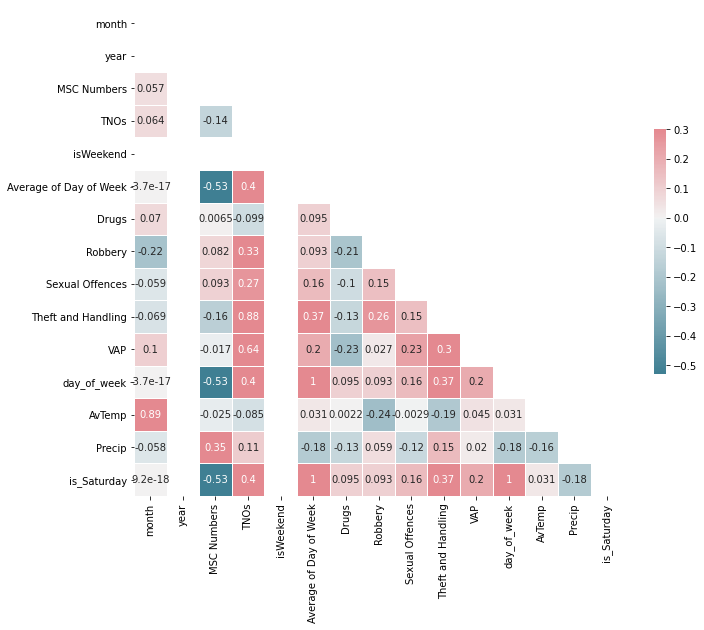

In [5]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [6]:
corr

,month,year,MSC Numbers,TNOs,isWeekend,Average of Day of Week,Drugs,Robbery,Sexual Offences,Theft and Handling,VAP,day_of_week,AvTemp,Precip,is_Saturday
month,1.000000e+00,NaN,0.056914,0.064429,NaN,-3.680038e-17,0.070487,-0.216802,-0.059046,-0.068807,0.102490,-3.680038e-17,0.885969,-0.057926,9.200094e-18
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MSC Numbers,5.691426e-02,NaN,1.000000,-0.135622,NaN,-5.281401e-01,0.006482,0.082291,0.092611,-0.158839,-0.017405,-5.281401e-01,-0.025138,0.346231,-5.281401e-01
TNOs,6.442894e-02,NaN,-0.135622,1.000000,NaN,4.033434e-01,-0.098554,0.332907,0.266886,0.879603,0.636447,4.033434e-01,-0.084617,0.106230,4.033434e-01
isWeekend,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average of Day of Week,-3.680038e-17,NaN,-0.528140,0.403343,NaN,1.000000e+00,0.095394,0.093161,0.156174,0.367383,0.204583,1.000000e+00,0.030875,-0.180412,1.000000e+00
Drugs,7.048678e-02,NaN,0.006482,-0.098554,NaN,9.539445e-02,1.000000,-0.208351,-0.101804,-0.126924,-0.231236,9.539445e-02,0.002160,-0.125068,9.539445e-02
Robbery,-2.168016e-01,NaN,0.082291,0.332907,NaN,9.316051e-02,-0.208351,1.000000,0.147917,0.261779,0.027145,9.316051e-02,-0.238847,0.058988,9.316051e-02
Sexual Offences,-5.904634e-02,NaN,0.092611,0.266886,NaN,1.561738e-01,-0.101804,0.147917,1.000000,0.147703,0.232367,1.561738e-01,-0.002928,-0.116149,1.561738e-01
Theft and Handling,-6.880737e-02,NaN,-0.158839,0.879603,NaN,3.673825e-01,-0.126924,0.261779,0.147703,1.000000,0.301379,3.673825e-01,-0.193821,0.154582,3.673825e-01


In [7]:
weekend_only.shape

(54, 17)

In [8]:
weekend_only.head()

,date_new,month,year,MSC Numbers,TNOs,isWeekend,Average of Day of Week,Drugs,Robbery,Sexual Offences,Theft and Handling,VAP,day_of_week,AvTemp,Precip,is_Saturday,date
date,,,,,,,,,,,,,,,,,
2018-01-26,2018-1-26,1,2018,0,1,1,5,0,1,0,0,0,6,7.35,0.0,0,2018-01-26
2018-01-27,2018-1-27,1,2018,0,2,1,6,0,0,0,1,1,7,11.10,0.9,1,2018-01-27
2018-02-02,2018-2-2,2,2018,9,8,1,5,0,1,0,4,2,6,6.05,0.0,0,2018-02-02
2018-02-03,2018-2-3,2,2018,4,16,1,6,0,2,0,11,2,7,4.25,4.8,1,2018-02-03
2018-02-09,2018-2-9,2,2018,10,12,1,5,0,1,0,7,2,6,3.60,7.7,0,2018-02-09


In [9]:
saturday_only = weekend_only[weekend_only["is_Saturday"] == 1]
friday_only = weekend_only[weekend_only["is_Saturday"] == 0]

In [10]:
#examining only Saturday
saturday_only.describe()

,month,year,MSC Numbers,TNOs,isWeekend,Average of Day of Week,Drugs,Robbery,Sexual Offences,Theft and Handling,VAP,day_of_week,AvTemp,Precip,is_Saturday
count,27.000000,27.0,27.000000,27.000000,27.0,27.0,27.000000,27.000000,27.000000,27.000000,27.000000,27.0,27.000000,27.000000,27.0
mean,4.370370,2018.0,3.740741,13.333333,1.0,6.0,0.407407,0.629630,0.259259,7.259259,3.222222,7.0,12.966667,1.062963,1.0
std,1.821837,0.0,2.639822,5.896544,0.0,0.0,0.636049,0.629294,0.525693,4.364125,2.154304,0.0,6.671106,1.898410,0.0
min,1.000000,2018.0,0.000000,2.000000,1.0,6.0,0.000000,0.000000,0.000000,1.000000,0.000000,7.0,0.000000,0.000000,1.0
25%,3.000000,2018.0,1.500000,10.500000,1.0,6.0,0.000000,0.000000,0.000000,3.000000,1.500000,7.0,8.250000,0.000000,1.0
50%,4.000000,2018.0,4.000000,12.000000,1.0,6.0,0.000000,1.000000,0.000000,6.000000,3.000000,7.0,13.000000,0.000000,1.0
75%,6.000000,2018.0,5.500000,17.000000,1.0,6.0,1.000000,1.000000,0.000000,10.500000,5.000000,7.0,18.850000,1.100000,1.0
max,7.000000,2018.0,9.000000,26.000000,1.0,6.0,2.000000,2.000000,2.000000,16.000000,8.000000,7.0,23.500000,7.300000,1.0


In [11]:
#examining only Friday
friday_only.describe()


,month,year,MSC Numbers,TNOs,isWeekend,Average of Day of Week,Drugs,Robbery,Sexual Offences,Theft and Handling,VAP,day_of_week,AvTemp,Precip,is_Saturday
count,27.000000,27.0,27.000000,27.000000,27.0,27.0,27.000000,27.000000,27.000000,27.000000,27.000000,27.0,27.000000,27.000000,27.0
mean,4.370370,2018.0,7.962963,9.111111,1.0,5.0,0.296296,0.518519,0.111111,4.518519,2.407407,6.0,12.577778,2.274074,0.0
std,1.821837,0.0,4.118266,3.587728,0.0,0.0,0.541708,0.579812,0.423659,2.439583,1.802973,0.0,6.147503,4.362744,0.0
min,1.000000,2018.0,0.000000,1.000000,1.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.0,0.650000,0.000000,0.0
25%,3.000000,2018.0,5.500000,7.000000,1.0,5.0,0.000000,0.000000,0.000000,3.000000,1.000000,6.0,7.875000,0.000000,0.0
50%,4.000000,2018.0,8.000000,9.000000,1.0,5.0,0.000000,0.000000,0.000000,4.000000,2.000000,6.0,12.000000,0.000000,0.0
75%,6.000000,2018.0,9.500000,12.000000,1.0,5.0,0.500000,1.000000,0.000000,6.500000,4.000000,6.0,17.700000,1.850000,0.0
max,7.000000,2018.0,18.000000,17.000000,1.0,5.0,2.000000,2.000000,2.000000,9.000000,7.000000,6.0,23.150000,16.900000,0.0


Not entirely surprisingly, we have a correlation between rain and volunteering - this is worth bearing in mind when considering rest of analysis.

We now have a dataset of 54 observations, that is configured to a daily frequency

In [12]:
weekend_only["DateClean"] = weekend_only["date"].dt.date
weekend_only["Weekday"] = weekend_only["day_of_week"]
weekend_only["Weekday"] = weekend_only["Weekday"].replace({6:"Friday", 7:"Saturday"})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


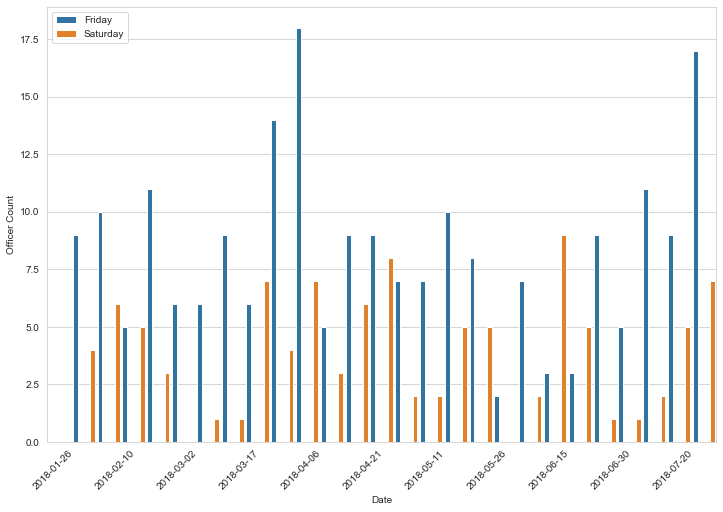

In [13]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, figsize=(12,8))
sns.barplot(data=weekend_only, x="DateClean", y="MSC Numbers", hue="Weekday", ax=ax)
ax.set(xlabel='Date', ylabel='Officer Count')
#ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.tick_params(axis='x', labelrotation = 45)

plt.xticks(range(0,weekend_only.shape[0],5))

#plt.legend(loc='upper left', labels=["Friday","Saturday"])
#ax.legend(labels=["Friday","Saturday"])
plt.legend(loc='upper left')

plt.savefig('dosage_by_day.eps', format='eps')
plt.show()

In [14]:
weekend_only.head()

,date_new,month,year,MSC Numbers,TNOs,isWeekend,Average of Day of Week,Drugs,Robbery,Sexual Offences,Theft and Handling,VAP,day_of_week,AvTemp,Precip,is_Saturday,date,DateClean,Weekday
date,,,,,,,,,,,,,,,,,,,
2018-01-26,2018-1-26,1,2018,0,1,1,5,0,1,0,0,0,6,7.35,0.0,0,2018-01-26,2018-01-26,Friday
2018-01-27,2018-1-27,1,2018,0,2,1,6,0,0,0,1,1,7,11.10,0.9,1,2018-01-27,2018-01-27,Saturday
2018-02-02,2018-2-2,2,2018,9,8,1,5,0,1,0,4,2,6,6.05,0.0,0,2018-02-02,2018-02-02,Friday
2018-02-03,2018-2-3,2,2018,4,16,1,6,0,2,0,11,2,7,4.25,4.8,1,2018-02-03,2018-02-03,Saturday
2018-02-09,2018-2-9,2,2018,10,12,1,5,0,1,0,7,2,6,3.60,7.7,0,2018-02-09,2018-02-09,Friday


In [15]:
## Descriptive Statistics

In [16]:
weekend_only_crimes = weekend_only[["TNOs","Drugs","Robbery","Theft and Handling","VAP"]]
weekend_only_crimes.describe()

,TNOs,Drugs,Robbery,Theft and Handling,VAP
count,54.000000,54.000000,54.000000,54.000000,54.000000
mean,11.222222,0.351852,0.574074,5.888889,2.814815
std,5.283176,0.587846,0.601942,3.765116,2.010107
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,0.000000,3.000000,1.000000
50%,11.000000,0.000000,1.000000,5.000000,2.000000
75%,13.750000,1.000000,1.000000,8.000000,4.000000
max,26.000000,2.000000,2.000000,16.000000,8.000000


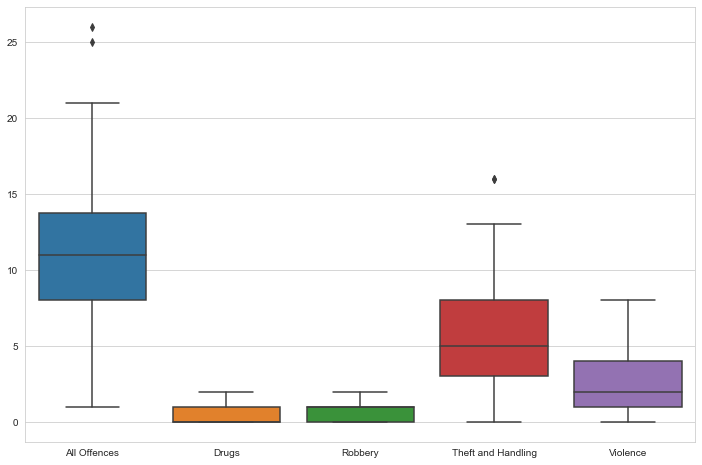

In [17]:
fig, ax = plt.subplots(1, figsize=(12,8))
sns.boxplot(data=weekend_only_crimes.rename(columns={"TNOs":"All Offences", "VAP":"Violence"}))
plt.savefig('crime_type_boxplot.eps', format='eps')


In [18]:
column_list = weekend_only.columns
column_list

Index(['date_new', 'month', 'year', 'MSC Numbers', 'TNOs', 'isWeekend',
       'Average of Day of Week', 'Drugs', 'Robbery', 'Sexual Offences',
       'Theft and Handling', 'VAP', 'day_of_week', 'AvTemp', 'Precip',
       'is_Saturday', 'date', 'DateClean', 'Weekday'],
      dtype='object')

As observed, we have a couple of missing observations.
We will start by using OLS regresion, and then compare to an ARIMA time series model
First, we need to analyse our data to settle on ARIMA terms.

P is the AutoRegressive term.
D is the differencing - if we want to remove our seasonable component.  Given we're in a "2 day season", it will be 1.
Q is the moving average.


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

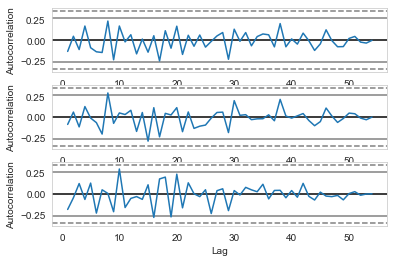

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(weekend_only["TNOs"], ax=ax1)
autocorrelation_plot(weekend_only["Theft and Handling"], ax=ax2)
autocorrelation_plot(weekend_only["VAP"], ax=ax3)

This suggests our P value will be 0 across all 3.

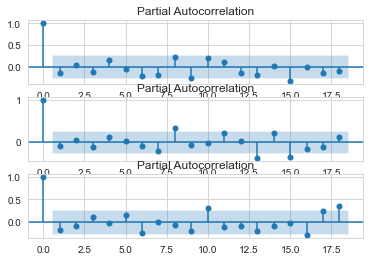

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_pacf(weekend_only["TNOs"], ax=ax1)
plot_pacf(weekend_only["Theft and Handling"], ax=ax2)
plot_pacf(weekend_only["VAP"], ax=ax3)
plt.show()

This suggests our Q value is 1

For our ARIMA model then, P = 0, D=1, Q=1 (though we will check for fit and tweak as we go along)

# Analysis
## Total Notifiable Offences

We begin by undertaking some comparative analysis.

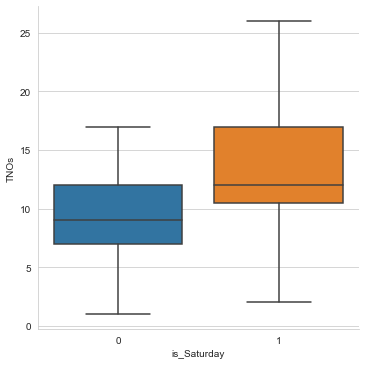

In [21]:
sns.catplot(x="is_Saturday", y="TNOs", kind='box', data=weekend_only.reset_index(drop=True));

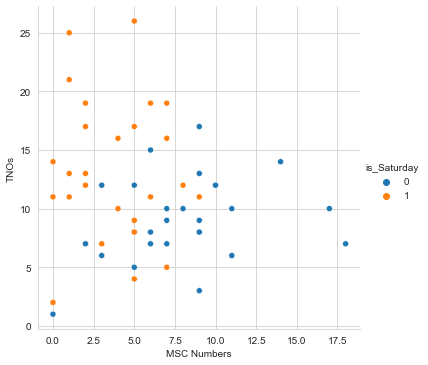

In [22]:
sns.relplot(x="MSC Numbers", y="TNOs", hue="is_Saturday", kind='scatter', data=weekend_only.reset_index(drop=True));

We now examine the relationship between dosage and TNOs, disaggregating by Saturday and Friday.

c:\users\admin\dropbox\data projects\nte_hotspot_policing\venv\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The Po

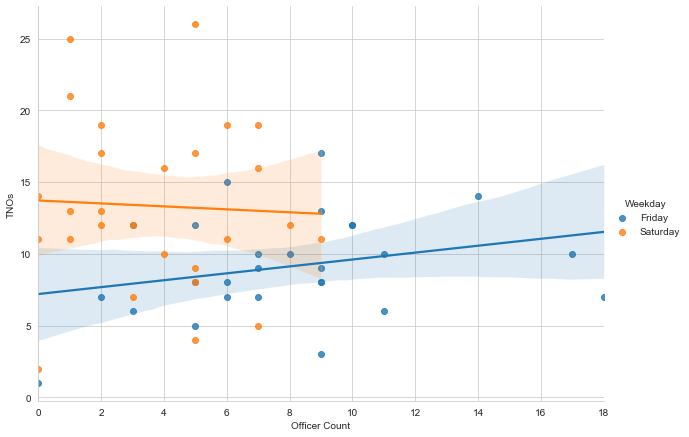

In [23]:
sns.set_style("whitegrid")

sns.lmplot(data=weekend_only.reset_index(drop=True).rename(columns={"MSC Numbers":"Officer Count"}),
           x="Officer Count", y="TNOs", hue="Weekday", size=6, aspect=1.4)

plt.savefig('weekday_relplot.eps', format='eps')
plt.show()


### OLS Regression (StatsModels Library)
OLS regression with Saturday, and MSC numbers on crime

In [24]:
X = weekend_only[['MSC Numbers','is_Saturday']]
# y = pd.DataFrame(weekend_only["TNOs"])
y = weekend_only["TNOs"]
# X = sm.add_constant(X.to_numpy())
X = sm.add_constant(X)
#We add a constant to our model (as there is no reason to think when our predictors are 0, crime is also 0)

model = sm.OLS(y, X).fit()
# make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TNOs   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     5.260
Date:                Sat, 03 Jul 2021   Prob (F-statistic):            0.00838
Time:                        07:34:11   Log-Likelihood:                -160.94
No. Observations:                  54   AIC:                             327.9
Df Residuals:                      51   BIC:                             333.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.9919      1.828      4.372      0.000       4.322      11.662
MSC Numbers     0.1406      0.197      0.715      0.478      -0.254       0.535
is_Saturday     4.8157      1.572      3.064      0.003       1.660       7.971
==============================================================================
Omnibus:                        1.786   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                1.018
Skew:                           0.277   Prob(JB):                        0.601
Kurtosis:                       3.382   Cond. No.                         24.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ARIMA (StatsModels Library)

In [25]:
features = [ "MSC Numbers", "is_Saturday", "AvTemp"]
# 0,1,1 ARIMA model
model = ARIMA_NEW(weekend_only["TNOs"], order=(0,1,1), exog=weekend_only[features], trend="t")
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TNOs   No. Observations:                   54
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -156.714
Date:                Sat, 03 Jul 2021   AIC                            325.429
Time:                        07:34:12   BIC                            337.250
Sample:                    01-26-2018   HQIC                           329.975
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
drift           0.2366      0.092      2.571      0.010       0.056       0.417
MSC Numbers     0.0141      0.267      0.053      0.958      -0.509       0.537
is_Saturday     4.2785      1.663      2.572      0.010       1.018       7.539
AvTemp         -0.5997      0.198     -3.032      0.002      -0.987      -0.212
ma.L1          -0.9999     63.726     -0.016      0.987    -125.901     123.901
sigma2         20.1002   1281.063      0.016      0.987   -2490.737    2530.937
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.96   Prob(JB):                         0.67
Heteroskedasticity (H):               0.51   Skew:                             0.30
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
features = [ "MSC Numbers", "is_Saturday", "AvTemp"]
# 0,1,1 ARIMA model
model = ARIMA_NEW(weekend_only["TNOs"], order=(0,1,1), exog=weekend_only[features])
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TNOs   No. Observations:                   54
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -160.082
Date:                Sat, 03 Jul 2021   AIC                            330.165
Time:                        07:34:12   BIC                            340.016
Sample:                    01-26-2018   HQIC                           333.953
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MSC Numbers     0.0925      0.262      0.353      0.724      -0.421       0.605
is_Saturday     4.6247      1.788      2.586      0.010       1.120       8.130
AvTemp         -0.2783      0.176     -1.582      0.114      -0.623       0.067
ma.L1          -0.8850      0.082    -10.767      0.000      -1.046      -0.724
sigma2         23.9058      4.680      5.108      0.000      14.733      33.079
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.73   Prob(JB):                         0.83
Heteroskedasticity (H):               0.57   Skew:                             0.19
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
features = ["MSC Numbers", "is_Saturday"]
# 0,1,1 ARIMA model
model = ARIMA(weekend_only["TNOs"], order=(0,1,1), exog=weekend_only[features])
model_fit = model.fit(disp=0)
model_fit.summary()


c:\users\admin\dropbox\data projects\nte_hotspot_policing\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.TNOs   No. Observations:                   53
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -159.046
Method:                       css-mle   S.D. of innovations              4.685
Date:                Sat, 03 Jul 2021   AIC                            328.092
Time:                        07:34:14   BIC                            337.944
Sample:                    01-27-2018   HQIC                           331.881
                         - 07-28-2018                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.9462      1.454     -2.026      0.043      -5.796      -0.096
MSC Numbers     -0.1522      0.086     -1.774      0.076      -0.320       0.016
is_Saturday      7.7380      2.579      3.001      0.003       2.684      12.792
ma.L1.D.TNOs    -1.0000      0.060    -16.708      0.000      -1.117      -0.883
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

Our final model includes temperature, leading to better fit, and leading to significance for our dosage. This suggests correlation between temperature and officer dosage, that we may not be able to disaggregate.


In [28]:
features = ["MSC Numbers","AvTemp", "is_Saturday"]
# 0,1,1 ARIMA model
model = ARIMA(weekend_only["TNOs"], order=(0,1,1), exog=weekend_only[features])
model_fit = model.fit(disp=0)
model_fit.summary()

c:\users\admin\dropbox\data projects\nte_hotspot_policing\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.TNOs   No. Observations:                   53
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -157.987
Method:                       css-mle   S.D. of innovations              4.593
Date:                Sat, 03 Jul 2021   AIC                            327.974
Time:                        07:34:15   BIC                            339.796
Sample:                    01-27-2018   HQIC                           332.520
                         - 07-28-2018                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.0516      1.550     -1.324      0.186      -5.089       0.985
MSC Numbers     -0.2257      0.098     -2.307      0.021      -0.417      -0.034
AvTemp          -0.0238      0.016     -1.470      0.142      -0.056       0.008
is_Saturday      7.4263      2.536      2.928      0.003       2.455      12.397
ma.L1.D.TNOs    -0.9997      0.051    -19.612      0.000      -1.100      -0.900
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0003           +0.0000j            1.0003            0.0000
-----------------------------------------------------------------------------
"""

In [29]:
weekend_only["Predicted TNOs"] = model_fit.predict(typ='levels')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


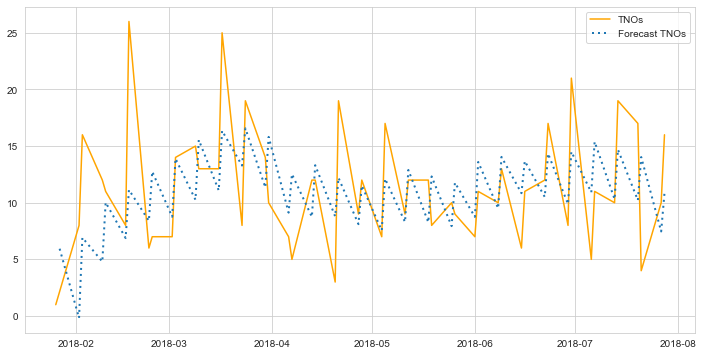

In [30]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(weekend_only["date"],
        weekend_only["TNOs"], label="TNOs", color="orange")

ax.plot(weekend_only["date"], weekend_only["Predicted TNOs"],
        label="Forecast TNOs",
        dashes=[0,1,1,1],
        linewidth=2)

plt.legend()
plt.savefig('model_forecast.eps', format='eps')

In [31]:
predictions = model_fit.predict(typ='levels')
mse = mean_squared_error(weekend_only["TNOs"].iloc[1:], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:23.366415772090274
RMSE:4.833882060217261


Examining our residuals and their distribution

<AxesSubplot:xlabel='date'>

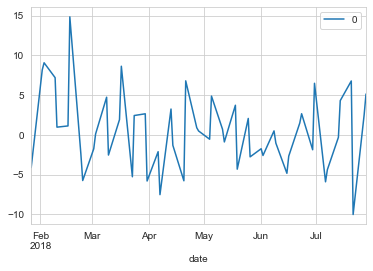

In [32]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

<AxesSubplot:ylabel='Density'>

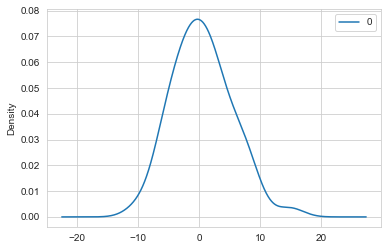

In [33]:
residuals.plot(kind="kde")

### Auto-ARIMA Model


In [34]:
features = ["MSC Numbers", "AvTemp", "is_Saturday"]

auto = pm.auto_arima(weekend_only["TNOs"],exogenous=weekend_only[features], d=1, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -160.082
Date:                Sat, 03 Jul 2021   AIC                            330.165
Time:                        07:34:27   BIC                            340.016
Sample:                    01-26-2018   HQIC                           333.953
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MSC Numbers     0.0925      0.262      0.353      0.724      -0.421       0.605
AvTemp         -0.2783      0.176     -1.582      0.114      -0.623       0.067
is_Saturday     4.6247      1.788      2.586      0.010       1.120       8.130
ma.L1          -0.8850      0.082    -10.767      0.000      -1.046      -0.724
sigma2         23.9058      4.680      5.108      0.000      14.733      33.079
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.73   Prob(JB):                         0.83
Heteroskedasticity (H):               0.57   Skew:                             0.19
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
predictions = auto.predict_in_sample(exogenous=weekend_only[features])

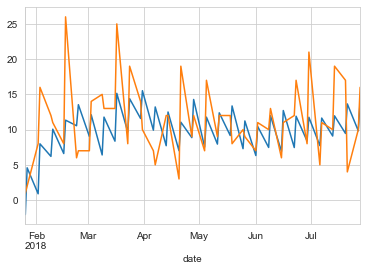

In [36]:
predictions.plot()
weekend_only["TNOs"].plot();

In [37]:
mse = mean_squared_error(weekend_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))


Mean Squared Error:24.457131801316844
RMSE:4.945415230424726


### Diagnostics


c:\users\admin\dropbox\data projects\nte_hotspot_policing\venv\lib\site-packages\pmdarima\utils\visualization.py:219: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  res = tsaplots.plot_acf(


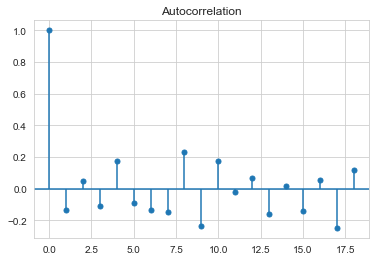

In [38]:
pm.plot_acf(weekend_only["TNOs"])

In [39]:
from pmdarima.arima.utils import ndiffs, nsdiffs

print(ndiffs(weekend_only["TNOs"], test='adf'))

1


In [40]:
nsdiffs(weekend_only["TNOs"],
        m=2,
        max_D=12,
        test='ch')

0

We attempt an explicitly seasonal model here.

In [41]:
weekend_only["MSC Numbers_x_is_Saturday"] = weekend_only["MSC Numbers"] * weekend_only["is_Saturday"]
features = ["MSC Numbers", "AvTemp", "is_Saturday", "MSC Numbers_x_is_Saturday"]
# features = ["MSC Numbers", "AvTemp", "is_Saturday"]
# features = ["MSC Numbers", "AvTemp"]

auto = pm.auto_arima(weekend_only["TNOs"],exogenous=weekend_only[features], d=1, seasonal=True, m=2, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -159.771
Date:                Sat, 03 Jul 2021   AIC                            331.542
Time:                        07:34:47   BIC                            343.364
Sample:                    01-26-2018   HQIC                           336.088
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
MSC Numbers                   0.1889      0.357      0.529      0.597      -0.511       0.889
AvTemp                       -0.2742      0.187     -1.464      0.143      -0.641       0.093
is_Saturday                   6.2465      3.807      1.641      0.101      -1.215      13.708
MSC Numbers_x_is_Saturday    -0.3244      0.554     -0.586      0.558      -1.410       0.761
ma.L1                        -0.8884      0.088    -10.123      0.000      -1.060      -0.716
sigma2                       23.6138      4.745      4.977      0.000      14.315      32.913
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 0.60
Prob(Q):                              0.75   Prob(JB):                         0.74
Heteroskedasticity (H):               0.53   Skew:                             0.26
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
predictions = auto.predict_in_sample(exogenous=weekend_only[features])

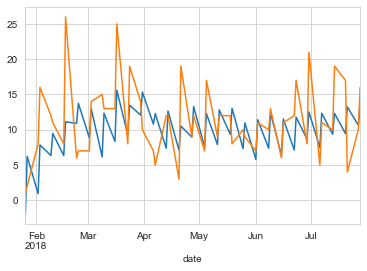

In [43]:
predictions.plot()
weekend_only["TNOs"].plot();

In [44]:
mse = mean_squared_error(weekend_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:24.289102375184864
RMSE:4.928397546382076


## Theft Offences

### OLS Regression

In [45]:
X = weekend_only[['is_Saturday','MSC Numbers',"AvTemp"]]
y = pd.DataFrame(weekend_only["Theft and Handling"])
X = sm.add_constant(X.to_numpy())

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Theft and Handling   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     3.625
Date:                Sat, 03 Jul 2021   Prob (F-statistic):             0.0191
Time:                        07:34:48   Log-Likelihood:                -142.40
No. Observations:                  54   AIC:                             292.8
Df Residuals:                      50   BIC:                             300.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7014      1.628      3.502      0.001       2.432       8.971
x1             2.9703      1.126      2.637      0.011       0.708       5.232
x2             0.0432      0.141      0.307      0.760      -0.240       0.326
x3            -0.1214      0.076     -1.598      0.116      -0.274       0.031
==============================================================================
Omnibus:                        1.359   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.507   Jarque-Bera (JB):                1.334
Skew:                           0.280   Prob(JB):                        0.513
Kurtosis:                       2.473   Cond. No.                         57.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ARIMA

In [46]:
#presence of 0 in our temp is now causing an error - we create a quick transform to account for this.
weekend_only["TempTransform"] = weekend_only["AvTemp"] + 1

In [47]:
features = ['MSC Numbers', "is_Saturday", "TempTransform"]
# 0,1,1 ARIMA model
model = ARIMA(weekend_only["Theft and Handling"], order=(0,1,1), exog=weekend_only[features])
model_fit = model.fit(disp=0)
model_fit.summary()


c:\users\admin\dropbox\data projects\nte_hotspot_policing\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                               
================================================================================
Dep. Variable:     D.Theft and Handling   No. Observations:                   53
Model:                   ARIMA(0, 1, 1)   Log Likelihood                -141.255
Method:                         css-mle   S.D. of innovations              3.349
Date:                  Sat, 03 Jul 2021   AIC                            294.510
Time:                          07:34:48   BIC                            306.331
Sample:                      01-27-2018   HQIC                           299.056
                           - 07-28-2018                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.3647      1.135     -1.203      0.229      -3.589       0.859
MSC Numbers                   -0.1536      0.071     -2.153      0.031      -0.293      -0.014
is_Saturday                    4.8505      1.850      2.622      0.009       1.225       8.476
TempTransform                 -0.0122      0.012     -1.034      0.301      -0.035       0.011
ma.L1.D.Theft and Handling    -1.0000      0.051    -19.605      0.000      -1.100      -0.900
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

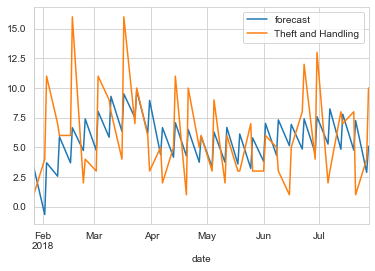

In [48]:
model_fit.plot_predict(exog=weekend_only[features])
plt.show()

### Auto-ARIMA Model


In [49]:
features = ["MSC Numbers", "AvTemp", "is_Saturday", "AvTemp"]

auto = pm.auto_arima(weekend_only["Theft and Handling"],exogenous=weekend_only[features], d=1, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -147.118
Date:                Sat, 03 Jul 2021   AIC                            308.236
Time:                        07:34:57   BIC                            322.028
Sample:                    01-26-2018   HQIC                           313.540
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MSC Numbers    -0.0198      0.181     -0.109      0.913      -0.375       0.336
AvTemp         -0.1455      0.079     -1.849      0.065      -0.300       0.009
is_Saturday     2.6632      1.076      2.474      0.013       0.554       4.773
AvTemp         -0.1455      0.079     -1.849      0.065      -0.300       0.009
ar.L1          -0.5972      0.132     -4.509      0.000      -0.857      -0.338
ar.L2          -0.3315      0.164     -2.025      0.043      -0.652      -0.011
sigma2         14.9560      3.745      3.994      0.000       7.617      22.295
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 1.27
Prob(Q):                              0.61   Prob(JB):                         0.53
Heteroskedasticity (H):               0.76   Skew:                            -0.03
Prob(H) (two-sided):                  0.56   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.53e+16. Standard errors may be unstable.
"""

In [50]:
features = ["MSC Numbers", "AvTemp", "is_Saturday", "AvTemp", "Precip"]

auto = pm.auto_arima(weekend_only["Theft and Handling"],exogenous=weekend_only[features], d=1, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(4, 1, 0)   Log Likelihood                -142.299
Date:                Sat, 03 Jul 2021   AIC                            304.598
Time:                        07:35:08   BIC                            324.301
Sample:                    01-26-2018   HQIC                           312.175
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MSC Numbers    -0.0975      0.212     -0.459      0.646      -0.513       0.319
AvTemp         -0.1241      0.096     -1.289      0.197      -0.313       0.065
is_Saturday     2.5775      1.102      2.340      0.019       0.418       4.737
AvTemp         -0.1241      0.096     -1.289      0.197      -0.313       0.065
Precip          0.1827      0.216      0.847      0.397      -0.240       0.606
ar.L1          -0.7293      0.158     -4.629      0.000      -1.038      -0.421
ar.L2          -0.6116      0.217     -2.813      0.005      -1.038      -0.185
ar.L3          -0.4660      0.182     -2.554      0.011      -0.824      -0.108
ar.L4          -0.3422      0.180     -1.905      0.057      -0.694       0.010
sigma2         12.3187      3.106      3.966      0.000       6.231      18.407
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.78
Prob(Q):                              0.88   Prob(JB):                         0.68
Heteroskedasticity (H):               0.85   Skew:                            -0.09
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.04e+17. Standard errors may be unstable.
"""

## Violence

### OLS Regression
OLS regression with Saturday, MSC Numbers, and Temperature on crime

In [51]:
X = weekend_only[['is_Saturday','MSC Numbers','AvTemp']]
y = pd.DataFrame(weekend_only["VAP"])
X = sm.add_constant(X.to_numpy())

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    VAP   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9664
Date:                Sat, 03 Jul 2021   Prob (F-statistic):              0.416
Time:                        07:35:08   Log-Likelihood:                -112.30
No. Observations:                  54   AIC:                             232.6
Df Residuals:                      50   BIC:                             240.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7499      0.932      1.877      0.066      -0.123       3.622
x1             1.0754      0.645      1.667      0.102      -0.220       2.371
x2             0.0629      0.081      0.779      0.439      -0.099       0.225
x3             0.0125      0.043      0.287      0.775      -0.075       0.100
==============================================================================
Omnibus:                        2.783   Durbin-Watson:                   2.295
Prob(Omnibus):                  0.249   Jarque-Bera (JB):                2.658
Skew:                           0.520   Prob(JB):                        0.265
Kurtosis:                       2.681   Cond. No.                         57.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ARIMA

In [58]:
features = ['MSC Numbers', "AvTemp", "is_Saturday"]
# 0,0,1 ARIMA model
model = ARIMA(weekend_only["VAP"], order=(0,1,1), exog=weekend_only[features])
model_fit = model.fit(disp=0)
model_fit.summary()


c:\users\admin\dropbox\data projects\nte_hotspot_policing\venv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.VAP   No. Observations:                   53
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -111.373
Method:                       css-mle   S.D. of innovations              1.906
Date:                Sat, 03 Jul 2021   AIC                            234.745
Time:                        07:49:04   BIC                            246.567
Sample:                    01-27-2018   HQIC                           239.291
                         - 07-28-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1987      0.643     -0.309      0.757      -1.459       1.062
MSC Numbers    -0.0575      0.041     -1.418      0.156      -0.137       0.022
AvTemp         -0.0095      0.007     -1.420      0.156      -0.023       0.004
is_Saturday     1.3525      1.053      1.285      0.199      -0.710       3.415
ma.L1.D.VAP    -1.0000      0.051    -19.758      0.000      -1.099      -0.901
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

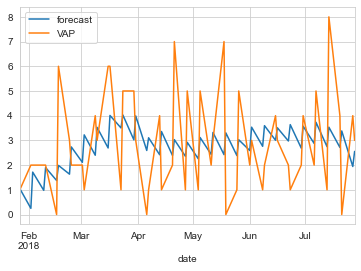

In [59]:
model_fit.plot_predict(exog=weekend_only[features])
plt.show()

### Auto-ARIMA Model


In [60]:
features = ["MSC Numbers", "AvTemp", "is_Saturday"]

auto = pm.auto_arima(weekend_only["VAP"],exogenous=weekend_only[features], d=1, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -116.173
Date:                Sat, 03 Jul 2021   AIC                            244.345
Time:                        07:49:10   BIC                            256.167
Sample:                    01-26-2018   HQIC                           248.891
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MSC Numbers     0.0145      0.087      0.167      0.868      -0.156       0.185
AvTemp         -0.0107      0.107     -0.100      0.920      -0.221       0.199
is_Saturday     0.9146      0.590      1.550      0.121      -0.242       2.071
ar.L1          -0.7972      0.160     -4.971      0.000      -1.112      -0.483
ar.L2          -0.5146      0.126     -4.089      0.000      -0.761      -0.268
sigma2          4.6102      1.082      4.262      0.000       2.490       6.730
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.48   Prob(JB):                         0.81
Heteroskedasticity (H):               1.10   Skew:                             0.06
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
predictions = auto.predict_in_sample(exogenous=weekend_only[features])
mse = mean_squared_error(weekend_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:97.21215651002038
RMSE:9.859622533850898


In [62]:
features = ["MSC Numbers", "AvTemp", "is_Saturday", "Precip"]

auto = pm.auto_arima(weekend_only["VAP"],exogenous=weekend_only[features], d=1, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -116.010
Date:                Sat, 03 Jul 2021   AIC                            246.020
Time:                        07:49:16   BIC                            259.812
Sample:                    01-26-2018   HQIC                           251.324
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MSC Numbers    -0.0050      0.086     -0.058      0.954      -0.174       0.164
AvTemp         -0.0023      0.110     -0.021      0.983      -0.218       0.213
is_Saturday     0.8920      0.609      1.466      0.143      -0.301       2.085
Precip          0.0482      0.075      0.639      0.523      -0.100       0.196
ar.L1          -0.8247      0.154     -5.343      0.000      -1.127      -0.522
ar.L2          -0.5246      0.124     -4.231      0.000      -0.768      -0.282
sigma2          4.5777      1.110      4.124      0.000       2.402       6.753
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 0.75
Prob(Q):                              0.47   Prob(JB):                         0.69
Heteroskedasticity (H):               1.07   Skew:                             0.17
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
predictions = auto.predict_in_sample(exogenous=weekend_only[features])
mse = mean_squared_error(weekend_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:97.17413794878067
RMSE:9.857694352574574


In [64]:
features = ["MSC Numbers", "AvTemp", "Precip"]

auto = pm.auto_arima(weekend_only["VAP"],exogenous=weekend_only[features], d=1, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -117.263
Date:                Sat, 03 Jul 2021   AIC                            246.525
Time:                        07:49:21   BIC                            258.347
Sample:                    01-26-2018   HQIC                           251.071
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MSC Numbers    -0.0884      0.069     -1.286      0.199      -0.223       0.046
AvTemp         -0.0172      0.108     -0.159      0.874      -0.229       0.195
Precip          0.0596      0.078      0.760      0.447      -0.094       0.213
ar.L1          -0.8504      0.153     -5.564      0.000      -1.150      -0.551
ar.L2          -0.5148      0.127     -4.040      0.000      -0.765      -0.265
sigma2          4.7988      1.130      4.246      0.000       2.584       7.014
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.46   Prob(JB):                         0.63
Heteroskedasticity (H):               0.89   Skew:                             0.20
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
predictions = auto.predict_in_sample(exogenous=weekend_only[features])
mse = mean_squared_error(weekend_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:99.70920584142458
RMSE:9.98544970651921


In [66]:
features = ["MSC Numbers", "AvTemp", "Precip", "is_Saturday"]

auto = pm.auto_arima(weekend_only["TNOs"],exogenous=weekend_only[features], d=1, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(6, 1, 1)   Log Likelihood                -153.683
Date:                Sat, 03 Jul 2021   AIC                            331.366
Time:                        07:49:28   BIC                            355.010
Sample:                    01-26-2018   HQIC                           340.458
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MSC Numbers    -0.0520      0.228     -0.228      0.819      -0.498       0.394
AvTemp         -0.1142      0.205     -0.558      0.577      -0.516       0.287
Precip          0.2377      0.277      0.858      0.391      -0.306       0.781
is_Saturday     4.4507      1.166      3.816      0.000       2.165       6.736
ar.L1          -0.0606      0.229     -0.264      0.792      -0.510       0.389
ar.L2          -0.2502      0.201     -1.243      0.214      -0.645       0.144
ar.L3          -0.0218      0.224     -0.097      0.923      -0.462       0.418
ar.L4          -0.1191      0.182     -0.655      0.512      -0.475       0.237
ar.L5           0.0702      0.178      0.395      0.693      -0.278       0.418
ar.L6          -0.4817      0.160     -3.005      0.003      -0.796      -0.167
ma.L1          -0.7829      0.170     -4.603      0.000      -1.116      -0.450
sigma2         18.1400      5.145      3.526      0.000       8.056      28.224
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.74
Prob(Q):                              0.83   Prob(JB):                         0.42
Heteroskedasticity (H):               0.87   Skew:                             0.25
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
predictions = auto.predict_in_sample(exogenous=weekend_only[features])
mse = mean_squared_error(weekend_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:28.456217418600836
RMSE:5.334436935478836


In [82]:
features = ["MSC Numbers", "AvTemp", "Precip", "is_Saturday"]

auto = pm.auto_arima(weekend_only["TNOs"],exogenous=weekend_only[features], d=1, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(6, 1, 1)   Log Likelihood                -153.683
Date:                Sat, 03 Jul 2021   AIC                            331.366
Time:                        08:04:07   BIC                            355.010
Sample:                    01-26-2018   HQIC                           340.458
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MSC Numbers    -0.0520      0.228     -0.228      0.819      -0.498       0.394
AvTemp         -0.1142      0.205     -0.558      0.577      -0.516       0.287
Precip          0.2377      0.277      0.858      0.391      -0.306       0.781
is_Saturday     4.4507      1.166      3.816      0.000       2.165       6.736
ar.L1          -0.0606      0.229     -0.264      0.792      -0.510       0.389
ar.L2          -0.2502      0.201     -1.243      0.214      -0.645       0.144
ar.L3          -0.0218      0.224     -0.097      0.923      -0.462       0.418
ar.L4          -0.1191      0.182     -0.655      0.512      -0.475       0.237
ar.L5           0.0702      0.178      0.395      0.693      -0.278       0.418
ar.L6          -0.4817      0.160     -3.005      0.003      -0.796      -0.167
ma.L1          -0.7829      0.170     -4.603      0.000      -1.116      -0.450
sigma2         18.1400      5.145      3.526      0.000       8.056      28.224
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.74
Prob(Q):                              0.83   Prob(JB):                         0.42
Heteroskedasticity (H):               0.87   Skew:                             0.25
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
predictions = auto.predict_in_sample(exogenous=weekend_only[features])
mse = mean_squared_error(weekend_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:19.77184131467986
RMSE:4.446553869535357


In [92]:
features = ["MSC Numbers", "AvTemp", "Precip", "MSC Numbers_x_is_Saturday"]

auto = pm.auto_arima(weekend_only["TNOs"],exogenous=weekend_only[features], d=1, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(4, 1, 0)   Log Likelihood                -161.011
Date:                Sat, 03 Jul 2021   AIC                            340.023
Time:                        08:07:54   BIC                            357.755
Sample:                    01-26-2018   HQIC                           346.842
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
MSC Numbers                  -0.4072      0.215     -1.898      0.058      -0.828       0.013
AvTemp                       -0.2550      0.250     -1.022      0.307      -0.744       0.234
Precip                        0.3370      0.223      1.514      0.130      -0.099       0.773
MSC Numbers_x_is_Saturday     0.6294      0.257      2.445      0.014       0.125       1.134
ar.L1                        -0.8797      0.168     -5.230      0.000      -1.209      -0.550
ar.L2                        -0.7862      0.166     -4.728      0.000      -1.112      -0.460
ar.L3                        -0.5655      0.179     -3.159      0.002      -0.916      -0.215
ar.L4                        -0.3949      0.174     -2.270      0.023      -0.736      -0.054
sigma2                       24.7792      5.283      4.690      0.000      14.425      35.134
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.79   Prob(JB):                         0.73
Heteroskedasticity (H):               0.65   Skew:                             0.24
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
predictions = auto.predict_in_sample(exogenous=weekend_only[features])
mse = mean_squared_error(weekend_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:25.40623436242617
RMSE:5.0404597372091136


In [94]:
features = ["MSC Numbers", "AvTemp", "Precip", "MSC Numbers_x_is_Saturday", "is_Saturday"]

auto = pm.auto_arima(weekend_only["TNOs"],exogenous=weekend_only[features], d=1, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(6, 1, 1)   Log Likelihood                -151.734
Date:                Sat, 03 Jul 2021   AIC                            329.468
Time:                        08:09:18   BIC                            355.082
Sample:                    01-26-2018   HQIC                           339.318
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
MSC Numbers                   0.1151      0.242      0.475      0.635      -0.360       0.590
AvTemp                       -0.1300      0.179     -0.727      0.467      -0.481       0.221
Precip                        0.1747      0.251      0.697      0.486      -0.317       0.666
MSC Numbers_x_is_Saturday    -0.7506      0.422     -1.777      0.076      -1.579       0.077
is_Saturday                   7.8796      2.110      3.735      0.000       3.745      12.014
ar.L1                        -0.0533      0.183     -0.291      0.771      -0.412       0.306
ar.L2                        -0.2564      0.175     -1.468      0.142      -0.599       0.086
ar.L3                        -0.0683      0.180     -0.378      0.705      -0.422       0.285
ar.L4                        -0.1519      0.157     -0.970      0.332      -0.459       0.155
ar.L5                        -0.0018      0.164     -0.011      0.991      -0.323       0.320
ar.L6                        -0.5933      0.148     -4.015      0.000      -0.883      -0.304
ma.L1                        -0.7811      0.162     -4.810      0.000      -1.099      -0.463
sigma2                       16.5226      5.329      3.100      0.002       6.078      26.967
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 1.53
Prob(Q):                              0.60   Prob(JB):                         0.47
Heteroskedasticity (H):               0.88   Skew:                             0.05
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
predictions = auto.predict_in_sample(exogenous=weekend_only[features])
mse = mean_squared_error(weekend_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:19.097166494756106
RMSE:4.370030491284484


In [84]:
features = ["MSC Numbers", "AvTemp", "Precip"]

auto = pm.auto_arima(weekend_only["TNOs"],exogenous=weekend_only[features], d=1, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -163.996
Date:                Sat, 03 Jul 2021   AIC                            337.993
Time:                        08:04:12   BIC                            347.844
Sample:                    01-26-2018   HQIC                           341.781
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MSC Numbers    -0.2933      0.242     -1.212      0.225      -0.768       0.181
AvTemp         -0.2702      0.210     -1.285      0.199      -0.682       0.142
Precip          0.2133      0.314      0.678      0.498      -0.403       0.830
ma.L1          -0.8815      0.100     -8.793      0.000      -1.078      -0.685
sigma2         27.7254      4.723      5.870      0.000      18.469      36.982
===================================================================================
Ljung-Box (L1) (Q):                   1.71   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.19   Prob(JB):                         0.10
Heteroskedasticity (H):               0.56   Skew:                             0.70
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
predictions = auto.predict_in_sample(exogenous=weekend_only[features])
mse = mean_squared_error(weekend_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:28.456217418600836
RMSE:5.334436935478836


In [86]:
features = ["MSC Numbers", "AvTemp", "Precip"]

auto = pm.auto_arima(weekend_only["TNOs"],exogenous=weekend_only[features], start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=12, max_q=12, max_P=12, max_Q=12, seasonal=True,
                     stepwise=True, suppress_warnings=True, max_D=12,
                     error_action='ignore')


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:                        SARIMAX   Log Likelihood                -164.647
Date:                Sat, 03 Jul 2021   AIC                            339.294
Time:                        08:04:13   BIC                            349.239
Sample:                    01-26-2018   HQIC                           343.130
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      12.9542      1.613      8.029      0.000       9.792      16.116
MSC Numbers    -0.2536      0.237     -1.068      0.285      -0.719       0.212
AvTemp         -0.0526      0.107     -0.494      0.621      -0.262       0.156
Precip          0.2544      0.332      0.766      0.444      -0.397       0.906
sigma2         26.0533      5.000      5.211      0.000      16.254      35.853
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):                 2.73
Prob(Q):                              0.42   Prob(JB):                         0.25
Heteroskedasticity (H):               0.54   Skew:                             0.49
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
predictions = auto.predict_in_sample(exogenous=weekend_only[features])
mse = mean_squared_error(weekend_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:26.053895266250702
RMSE:5.104301643344631


In [88]:
features = ["MSC Numbers", "AvTemp", "Precip"]

auto = pm.auto_arima(weekend_only["TNOs"],exogenous=weekend_only[features], seasonal=True)


auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:                        SARIMAX   Log Likelihood                -164.647
Date:                Sat, 03 Jul 2021   AIC                            339.294
Time:                        08:04:14   BIC                            349.239
Sample:                    01-26-2018   HQIC                           343.130
                         - 07-28-2018                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      12.9542      1.613      8.029      0.000       9.792      16.116
MSC Numbers    -0.2536      0.237     -1.068      0.285      -0.719       0.212
AvTemp         -0.0526      0.107     -0.494      0.621      -0.262       0.156
Precip          0.2544      0.332      0.766      0.444      -0.397       0.906
sigma2         26.0533      5.000      5.211      0.000      16.254      35.853
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):                 2.73
Prob(Q):                              0.42   Prob(JB):                         0.25
Heteroskedasticity (H):               0.54   Skew:                             0.49
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
predictions = auto.predict_in_sample(exogenous=weekend_only[features])
mse = mean_squared_error(weekend_only["TNOs"], predictions)
print("Mean Squared Error:" + str(mse))
print("RMSE:" + str(np.sqrt(mse)))

Mean Squared Error:26.053895266250702
RMSE:5.104301643344631


we probably have missing observations that are screwing up our seasonality.  Let's get those dealt with.
We shouldn't need to explicitly add Saturday.  It's seasonal, that's the point.

